# Classifying Key Signatures for All Transpositions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('../modules')
from music_project import Analyzer

## Load data

In [2]:
csv_dir = '../csv/hymns_single-tone_alltranspositions_nosampling.csv'
df = pd.read_csv(csv_dir, index_col=0)
X = df[[str(n) for n in range(11)]]
y = df['sig']
ana = Analyzer(X, y)
ana.train_test_split(test_size=0.2, random_state=42)

## Clustering and Manifold Learning

### K-means Clustering

In [3]:
ana.fit_kmeans(name='kmeans', random_state=42)

Best clustering: KMeans(init='random', n_clusters=12, n_init=100, random_state=42)
Info score for cluster: 0.9387830816001539


### Gaussian Mixture Model

In [4]:
ana.fit_gmm(name='gmm', random_state=42)

Best clustering: GaussianMixture(n_components=12, random_state=42)
Info score for cluster: 0.8884010802160631


### DBSCAN

In [5]:
eps_vals = np.linspace(0.01,0.2,20)
min_samples_vals = list(range(1,8))
ana.fit_dbscan(name='dbscan', eps_vals=eps_vals, min_samples_vals=min_samples_vals, random_state=42)

Best clustering: DBSCAN(eps=0.09, n_jobs=-1)
Info score for cluster: 0.9564561344691858
Best eps: 0.09
Best min_samples: 5


### t-SNE

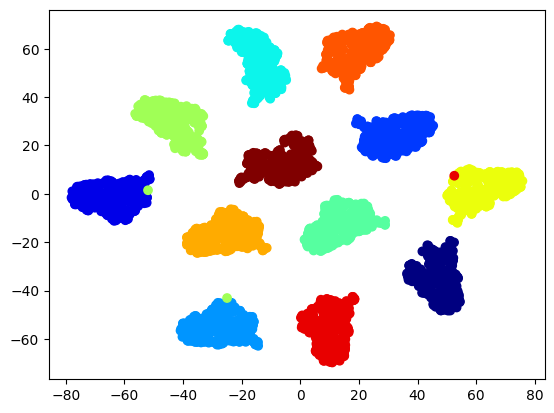

In [6]:
ana.fit_tsne(name='tsne', random_state=42)
fig, ax = ana.plot_embedding('tsne')
plt.show()

## Classification

### Logistic Regression

In [7]:
params = {}
params['l1_ratio'] = np.linspace(0,1,6)
params['C'] = np.power(10, np.linspace(2,4,6))
params['penalty'] = ['elasticnet']
params['solver'] = ['saga']
params['max_iter'] = [10000]
ana.train_model_gscv(LogisticRegression, name='logreg', params=params, random_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Scores for 'logreg':
Training score: 1.0
Test score: 0.998849252013809
 
Best params:
{'C': 1584.893192461114, 'l1_ratio': 1.0, 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'}
 


### Support Vector Classifier

#### Radial basis kernel

In [8]:
params = {}
params['C'] = np.power(10, np.linspace(-1, 3, 6))
params['kernel'] = ['rbf']
ana.train_model_gscv(SVC, 'svc-rbf', params=params, random_state=42)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Scores for 'svc-rbf':
Training score: 1.0
Test score: 1.0
 
Best params:
{'C': 158.48931924611142, 'kernel': 'rbf'}
 


#### Polynomial kernels

In [9]:
for degree in range(1,6):
    params = {}
    params['C'] = np.power(10, np.linspace(-1, 3, 5))
    params['coef0'] = [0, 1]
    params['kernel'] = ['poly']
    params['degree'] = [degree]
    ana.train_model_gscv(SVC, name=f'svc-poly-{degree}', params=params, random_state=42)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Scores for 'svc-poly-1':
Training score: 1.0
Test score: 0.998849252013809
 
Best params:
{'C': 100.0, 'coef0': 0, 'degree': 1, 'kernel': 'poly'}
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Scores for 'svc-poly-2':
Training score: 1.0
Test score: 1.0
 
Best params:
{'C': 10.0, 'coef0': 1, 'degree': 2, 'kernel': 'poly'}
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Scores for 'svc-poly-3':
Training score: 1.0
Test score: 1.0
 
Best params:
{'C': 10.0, 'coef0': 1, 'degree': 3, 'kernel': 'poly'}
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Scores for 'svc-poly-4':
Training score: 1.0
Test score: 1.0
 
Best params:
{'C': 1.0, 'coef0': 1, 'degree': 4, 'kernel': 'poly'}
 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Scores for 'svc-poly-5':
Training score: 1.0
Test score: 0.998849252013809
 
Best params:
{'C': 10.0, 'coef0': 0, 'degree': 5, 'kernel': 'poly'}
 


### Decision Tree

#### Pre-pruned (via GridSearchCV)

In [10]:
params = {}
params['criterion'] = ['gini', 'entropy', 'log_loss']
params ['max_depth'] = list(range(1,11))
params['min_samples_split'] = list(range(2,11))
params['min_samples_leaf'] = list(range(1,6))
ana.train_model_gscv(DecisionTreeClassifier, name='dt-gscv', params=params, random_state=42)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Scores for 'dt-gscv':
Training score: 1.0
Test score: 0.9758342922899885
 
Best params:
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
 


#### Post-pruned (with cost-complexity)

In [11]:
ana.train_tree_ccp(name='dt-ccp', val_size=0.2, random_state=42)

Scores for 'dt-ccp':
Training score: 0.998273381294964
Test score: 0.9815880322209436
 
ccp_alpha: 0.00035971223021582735
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
 


### Ensemble models

#### Random Forest

In [12]:
params = {}
params['n_estimators'] = [30, 100, 300]
params['max_features'] = ['sqrt', None]
ana.train_model_gscv(RandomForestClassifier, name='rf', params=params, random_state=42)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Scores for 'rf':
Training score: 1.0
Test score: 0.9919447640966629
 
Best params:
{'max_features': 'sqrt', 'n_estimators': 300}
 


#### Gradient Boosting

In [13]:
params = {}
params['learning_rate'] = [0.03, 0.1, 0.3]
params['n_estimators'] = [30, 100, 300]
params['subsample'] = [0.5, 1]
params['max_features'] = ['sqrt', None]
ana.train_model_gscv(GradientBoostingClassifier, name='gradboost', params=params, random_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Scores for 'gradboost':
Training score: 1.0
Test score: 0.9884925201380897
 
Best params:
{'learning_rate': 0.3, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.5}
 


### Projection

In [14]:
ana.train_projection('proj')

Scores for 'proj':
Training score: 0.9723741007194244
Test score: 0.9712313003452244
 


## Save Analyzer

In [15]:
print(ana)

Models:
logreg: GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([  100.        ,   251.18864315,   630.95734448,  1584.89319246,
        3981.07170553, 10000.        ]),
                         'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                         'max_iter': [10000], 'penalty': ['elasticnet'],
                         'solver': ['saga']},
             verbose=3)
svc-rbf: GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 6.30957344e-01, 3.98107171e+00, 2.51188643e+01,
       1.58489319e+02, 1.00000000e+03]),
                         'kernel': ['rbf']},
             verbose=3)
svc-poly-1: GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'coef0': [0, 1], 'degree': [1], 'kernel': ['poly']},
             verbose=3)
svc-poly-2: GridSearchCV(es

In [16]:
save_dir = '../models/part_1_hymns/'
with open(save_dir + 'analyzer_sig_alltrans_nosamp.pkl', 'wb') as f:
    pickle.dump(ana, f)